In [2]:
data_path = "../../data/ys/puppeteer_out/"
from glob import glob
import cv2
import numpy as np
from collections import defaultdict
from keras.layers import Input, Dense, Conv2D, MaxPooling2D,Flatten,Reshape, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.models import Model, Sequential
from keras import backend as K
from keras.callbacks import ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import os
import gc
print(os.getcwd())

/home/me/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


/home/me/code/project_screenshots/research/ys


In [3]:
imgs = defaultdict(list)
# keys = ["ys", "tnr", "ubuntu", "helv", "arial", "sansserif"]
keys = ["ys", "arial"]
# resize_to = w, h = (800, 200)
resize_to = w, h = (300, 300)

for k in keys:
  for filename in glob(data_path + "*" + k + "*"):
    img = cv2.imread(filename, cv2.IMREAD_COLOR)
    for r in range(20):
      row = np.random.randint(250, img.shape[0] - img.shape[0] // 3)
      col = np.random.randint(100, img.shape[1] - 600)
      w = np.random.randint(200, 400)
      h = np.random.randint(200, 400)
      if row + h < img.shape[0] and col + w < img.shape[1]:
        img_cut = img[row:row + h, col:col + w]
        img_cut = cv2.resize(img_cut, resize_to)
        white_number = (np.sum(img_cut, axis=2) > 600).sum()
#         print(white_number, img_cut.shape[0] * img_cut.shape[1])
#         cv2.imwrite("{0}.jpg".format(r), img_cut)
        if white_number > .95 * img_cut.shape[0] * img_cut.shape[1]:
#             print("Skipped")
            continue
        imgs[k].append(img_cut)

# for k in keys:
#   for filename in glob(data_path + "*" + k + "*")[:100]:
#     img = cv2.imread(filename, cv2.IMREAD_COLOR)
#     for r in range(4):
#       row = np.random.randint(200, img.shape[0] - 800)
#       h = np.random.randint(50, 300)
#       if row + h < img.shape[0]:
#         img_cut = img[row:row + h, 50:-300]
#         img_cut = cv2.resize(img_cut, resize_to)
#         imgs[k].append(img_cut)

# for k in keys:
#   for filename in glob(data_path + "*" + k + "*"):
#     img = cv2.imread(filename, cv2.IMREAD_COLOR)
#     img = img[:800, :600]
#     imgs[k].append(img)
#     for r in range(4):
#       row = np.random.randint(200, img.shape[0] - 800)
#       h = np.random.randint(50, 300)
#       if row + h < img.shape[0]:
#         img_cut = img[row:row + h, 50:-300]
#         img_cut = cv2.resize(img_cut, resize_to)
#         imgs[k].append(img_cut)

In [4]:
X = []
y_values = []
num_classes = 2

for i, k in enumerate(keys):
  X += imgs[k]
  y_values += [i] * len(imgs[k])

X = np.stack(X, axis=3)
X = np.rollaxis(X, 3, 0)
y = np.zeros((X.shape[0], num_classes), np.int32)
y[np.arange(len(y_values)), y_values] = 1
print(X.shape, y.shape)

(17640, 300, 300, 3) (17640, 2)


In [5]:
del imgs
gc.collect()
idx = np.random.permutation(len(y))
X = X[idx].astype(float)
y = y[idx].astype(float)
min_X = np.min(X, axis=0) 
max_X = np.max(X, axis=0)
print(min_X.shape, max_X.shape)
X[:] -= min_X
X[:] /= np.maximum(1, (max_X - min_X))
print(X.shape, y.shape)
print(y[:, 0].sum(), y[:, 1].sum())

(300, 300, 3) (300, 300, 3)
(17640, 300, 300, 3) (17640, 2)
9009.0 8631.0


[0. 1.]


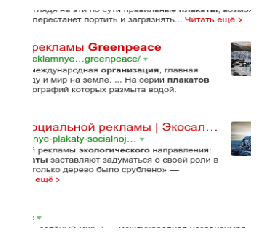

In [9]:
plt.axis("off")
# for i in range(10):
i = 7
plt.imshow(X[i])
print(y[i])
cv2.imwrite("test.png", (255 * X[i]).astype(np.uint8))
plt.show()

In [15]:
num_classes = 2

model = Sequential()
# input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(8, (3, 3), activation='relu', input_shape=X[0].shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(5, 5)))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(5, 5)))
model.add(Dropout(0.05))

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization())
# model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(5, 5)))
model.add(Dropout(0.05))

model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(num_classes, activation='softmax'))

# model = Sequential()

# model.add(Conv2D(16, (32, 32), activation='relu', input_shape=(X[0].shape)))
# #model.add(Dropout(0.25))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(32, 32)))
# # model.add(MaxPooling2D(pool_size=(32, 32)))
# # model.add(Conv2D(32, (64, 64), activation='relu', input_shape=(X[0].shape)))
# model.add(Conv2D(32, (16, 16), activation='relu'))
# #model.add(Dropout(0.25))
# # model.add(MaxPooling2D(pool_size=(10, 10)))
# # model.add(Conv2D(16, (8, 8), activation='relu'))
# #model.add(Dropout(0.25))
# # model.add(MaxPooling2D(pool_size=(8, 8)))
# # model.add(Conv2D(2, (3, 3), activation='relu'))
# # model.add(MaxPooling2D(pool_size=(10, 10)))
# # model.add(Conv2D(10, (40, 40), activation='relu', input_shape=(X[0].shape)))
# # model.add(Conv2D(10, (5, 5), activation='relu'))
# # model.add(MaxPooling2D(pool_size=(24, 24)))
# # model.add(MaxPooling2D(pool_size=(4, 4)))
# # model.add(Dropout(0.5))
# model.add(Flatten())
# # model.add(Dense(300, activation='relu'))
# #model.add(Dropout(0.5))
# model.add(Dense(30, activation='relu'))
# model.add(Dense(30, activation='relu'))
# model.add(Dense(30, activation='relu'))
# #model.add(Dropout(0.5))
# # model.add(Dropout(0.5))
# # model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

model.compile(loss="categorical_crossentropy",
#               optimizer=SGD(lr=0.01),
             optimizer="adam",
              metrics=['accuracy'])

nepochs = 400

In [ ]:


class NBatchLogger(Callback):
    def __init__(self, display):
        self.seen = 0
        self.display = display

    def on_batch_end(self, batch, logs={}):
        self.seen += logs.get('size', 0)
        if self.seen % self.display == 0:
            metrics_log = ''
            for k in self.params['metrics']:
                if k in logs:
                    val = logs[k]
                    if abs(val) > 1e-3:
                        metrics_log += ' - %s: %.4f' % (k, val)
                    else:
                        metrics_log += ' - %s: %.4e' % (k, val)
            print('{}/{} ... {}'.format(self.seen,
                                        nepochs,
                                        metrics_log))

In [108]:
print(len(np.where(y[4:8, 0] == 0)[0]))
print(len(np.where(y[4:8, 0] == 1)[0]))

1
3


In [ ]:
# out_batch = NBatchLogger(display=10)
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True, save_weights_only=True)

split = 15000

history = model.fit(X[:split], y[:split],
              epochs=nepochs,
              batch_size=10,
              shuffle=True,
              verbose=1,
              validation_data=(X[split:], y[split:]),
#               callbacks=[])
              callbacks=[checkpointer])

Train on 15000 samples, validate on 2640 samples
Epoch 1/400
15000/15000 [==============================] - 47s 3ms/step - loss: 0.6995 - acc: 0.5303 - val_loss: 0.7155 - val_acc: 0.5053

Epoch 00001: val_loss improved from inf to 0.71551, saving model to weights.hdf5
Epoch 2/400
15000/15000 [==============================] - 47s 3ms/step - loss: 0.6642 - acc: 0.5950 - val_loss: 0.6636 - val_acc: 0.5864

Epoch 00002: val_loss improved from 0.71551 to 0.66359, saving model to weights.hdf5
Epoch 3/400
15000/15000 [==============================] - 47s 3ms/step - loss: 0.6399 - acc: 0.6321 - val_loss: 0.6155 - val_acc: 0.6754

Epoch 00003: val_loss improved from 0.66359 to 0.61548, saving model to weights.hdf5
Epoch 4/400
15000/15000 [==============================] - 47s 3ms/step - loss: 0.5413 - acc: 0.7229 - val_loss: 0.8095 - val_acc: 0.6019

Epoch 00004: val_loss did not improve from 0.61548
Epoch 5/400
15000/15000 [==============================] - 47s 3ms/step - loss: 0.4191 - acc:

15000/15000 [==============================] - 47s 3ms/step - loss: 0.1823 - acc: 0.9344 - val_loss: 0.1999 - val_acc: 0.9227

Epoch 00041: val_loss did not improve from 0.18420
Epoch 42/400
15000/15000 [==============================] - 46s 3ms/step - loss: 0.1873 - acc: 0.9315 - val_loss: 0.1806 - val_acc: 0.9367

Epoch 00042: val_loss improved from 0.18420 to 0.18057, saving model to weights.hdf5
Epoch 43/400
15000/15000 [==============================] - 46s 3ms/step - loss: 0.1847 - acc: 0.9334 - val_loss: 0.2254 - val_acc: 0.9098

Epoch 00043: val_loss did not improve from 0.18057
Epoch 44/400
15000/15000 [==============================] - 46s 3ms/step - loss: 0.1845 - acc: 0.9329 - val_loss: 0.2491 - val_acc: 0.9019

Epoch 00044: val_loss did not improve from 0.18057
Epoch 45/400
15000/15000 [==============================] - 46s 3ms/step - loss: 0.1777 - acc: 0.9361 - val_loss: 0.2014 - val_acc: 0.9208

Epoch 00045: val_loss did not improve from 0.18057
Epoch 46/400
15000/15000

### Tesing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 800, 600, 3)


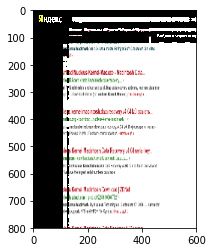

In [91]:
img = cv2.imread("test_ys.png")
img = cv2.resize(img, (600, 800)).astype(float)
img -= min_X
img /= np.maximum(1, (max_X - min_X))
plt.imshow(img)
img = img[np.newaxis]
print(img.shape)

In [92]:
model.predict(img)

array([[1., 0.]], dtype=float32)